In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from NeuralNetwork import NeuralNetwork
import numpy as np
import sklearn
from Config import cfg
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

def add_polynomials(X, num_poly):
    poly = PolynomialFeatures(num_poly)
    X = poly.fit_transform(X)
    return X

def mse(pred, actual):
    return np.mean(np.square(pred - actual))

def R_squared(pred, actual):
        r_sq = 1 - mse(pred, actual)/ mse(actual.mean(), actual)
        return r_sq
    
def normalize_data(X_train, X_test, y_train, y_test, normalize_y = False):
    # Checking for constant column and removing it to keep it as ones
    condition = np.all(X_train[:,0] == 1)
    if condition:
        X_train = X_train[:,1:]
        X_test = X_test[:,1:]
    
    if normalize_y:
        
        train_data = np.concatenate((X_train, y_train.reshape(-1,1)), axis = 1)
        test_data = np.concatenate((X_test, y_test.reshape(-1,1)), axis = 1)
    
    else:
        train_data = X_train
        test_data = X_test

    # Scale data to 0 mean and 1 standard deviation
    scaler = StandardScaler(with_mean=True).fit(train_data)

    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    
    if normalize_y:
        
        y_train = train_data[:,-1]
        y_test = test_data[:,-1]

        X_train = train_data[:,:-1]
        X_test = test_data[:,:-1]
        
    else:
        X_train = train_data
        y_train = y_train
        
        X_test = test_data
        y_test = y_test

#     assert X_train.shape != train_data.shape

    # Adding back constant column if it was present
    if condition:
        X_train = np.concatenate([np.ones((len(X_train), 1)), X_train], axis = 1)
        X_test = np.concatenate([np.ones((len(X_test), 1)), X_test], axis = 1)

    return X_train, X_test, y_train, y_test


def get_results(preds, actual):
    results = pd.DataFrame()
    results['preds'] = preds.flatten()
    results['targets'] = actual.flatten()
    results = results.sort_values('preds', ascending = False).reset_index(drop=True)
    results['model'] = np.cumsum(results.targets)
    results['optimal'] = results.targets.sort_values(ascending = False).values
    results['best_curve'] = np.cumsum(results.optimal)
    step = np.sum(results.targets).astype('float') / len(results)
    results['baseline'] = np.arange(start = step,stop = np.sum(results.targets)+step, step = step)
    results['model_diff'] = results.model - results.baseline
    results['optimal_diff'] = results.best_curve - results.baseline
    return results

def area_ratio(pred, actual):
    res = get_results(pred, actual)
    return res.model_diff.sum() / res.optimal_diff.sum()

def plot_lift(pred, actual):
    results = get_results(pred, actual)
    fig, ax = plt.subplots(figsize = (12,10))
    results[['model', 'best_curve', 'baseline']].plot(ax = ax, linewidth = 3, alpha = 0.8)
    plt.xlabel("Number of total data")
    plt.ylabel("Cumulative number of target data")
    plt.title("Lift chart")
    plt.show()

# Credit card data

In [2]:
df = pd.read_excel("data/default of credit card clients.xls")
df = df.iloc[1:, 1:]
categorical = ['X2', 'X3', 'X4']


X = df.drop('Y', axis = 1)
y = df.Y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
columns = X_train.columns
encode = [True if i in categorical else False for i in columns]
enc = OneHotEncoder(categorical_features = encode)
enc.fit(X_train)

X_train = enc.transform(X_train).toarray()
X_test = enc.transform(X_test).toarray()

X_train, X_test, y_train, y_test = normalize_data( X_train, X_test, y_train, y_test)
X_train = X_train.astype('float')
X_test = X_test.astype('float')

y_test = y_test.astype('float').reshape(-1,1)
y_train = y_train.astype('float').reshape(-1,1)

C:\Users\johan\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\johan\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [3]:
nn = NeuralNetwork(X_train, y_train, (X_test, y_test), 
                   [300, 100, 50, 20, 10, 1], 
                   ['relu', 'relu','relu', 'relu','relu', 'sigmoid'], 
                   'logistic')
nn.train(512, 300, 0.01, 0.1)

EPOCH 0 :
logistic cost: 0.6850116018782888
validaltion logistic cost: 0.6855715474136399


EPOCH 30 :
logistic cost: 0.491378655526907
validaltion logistic cost: 0.4998516094346743


EPOCH 60 :
logistic cost: 0.4482991780469317
validaltion logistic cost: 0.45682490147720833


EPOCH 90 :
logistic cost: 0.43001554134730674
validaltion logistic cost: 0.43976453021683026


EPOCH 120 :
logistic cost: 0.4284475047093536
validaltion logistic cost: 0.43751312435012724


EPOCH 150 :
logistic cost: 0.4267575666175487
validaltion logistic cost: 0.43623884005610164


EPOCH 180 :
logistic cost: 0.4247878674926919
validaltion logistic cost: 0.43553368649550656


EPOCH 210 :
logistic cost: 0.423287586415574
validaltion logistic cost: 0.4356402816920713


EPOCH 240 :
logistic cost: 0.420950238517572
validaltion logistic cost: 0.43628389188864564


EPOCH 270 :
logistic cost: 0.4174797179615622
validaltion logistic cost: 0.43735689868988076


EPOCH 299 :
logistic : 0.41312115241531744
validaltion logis

In [4]:
test_pred = nn.predict(X_test)
train_pred = nn.predict(X_train)

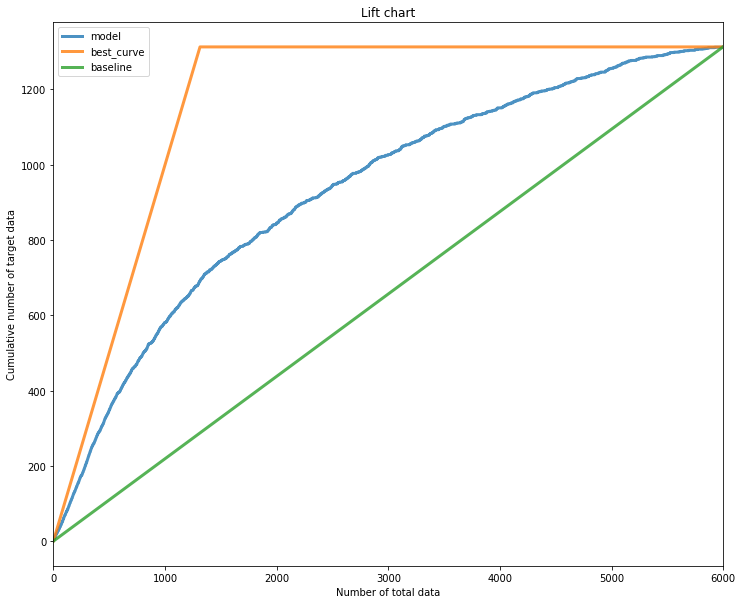

In [5]:
plot_lift(test_pred, y_test)

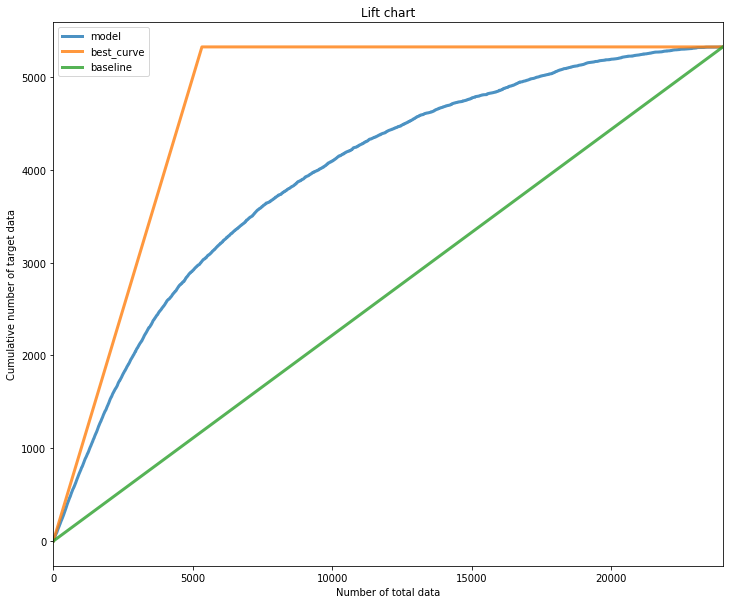

In [6]:
plot_lift(train_pred, y_train)

In [7]:
area_ratio(test_pred, y_test), area_ratio(train_pred, y_train)

(0.5356380232728759, 0.6193168516289221)

# Terrain data

In [8]:
df = pd.read_csv(cfg.TERRAIN_DATA)

df = df[['x1', 'x2', 'y']]
ind = [i for i in range(len(df))]
np.random.shuffle(ind)
ind = ind[:10000]

split_point = int(0.8*len(ind))
train = ind[:split_point]
test = ind[split_point : ]

train = df.iloc[train]
test = df.iloc[test]

X_train = train.drop('y', axis = 1).values
X_test = test.drop('y', axis = 1).values
y_train = train.y.values
y_test = test.y.values

X_train, X_test, y_train, y_test = normalize_data(X_train, X_test, y_train, y_test, True)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

C:\Users\johan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\johan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\johan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
nn = NeuralNetwork(X_train, y_train, (X_test, y_test), 
                   [300, 100, 50, 20, 10, 1], 
                   ['relu', 'relu','relu', 'relu','relu', 'linear'], 
                   'mse')

In [10]:
nn.train(512, 1000, 0.01)

EPOCH 0 :
mse cost: 0.5460155360252376
validaltion mse cost: 0.5003172392378676


EPOCH 100 :
mse cost: 0.26829187951429856
validaltion mse cost: 0.3120255116898064


EPOCH 200 :
mse cost: 0.2499712807686131
validaltion mse cost: 0.29699402079030235


EPOCH 300 :
mse cost: 0.24260455739104292
validaltion mse cost: 0.2908471867183125


EPOCH 400 :
mse cost: 0.23240677752049166
validaltion mse cost: 0.281731498676291


EPOCH 500 :
mse cost: 0.21441622912036898
validaltion mse cost: 0.26534584097247355


EPOCH 600 :
mse cost: 0.19803934158160602
validaltion mse cost: 0.2502192061247231


EPOCH 700 :
mse cost: 0.1971616484118494
validaltion mse cost: 0.2373028698246737


EPOCH 800 :
mse cost: 0.1956059606305998
validaltion mse cost: 0.23376829425741255


EPOCH 900 :
mse cost: 0.19359952589038856
validaltion mse cost: 0.23054209495359987


EPOCH 999 :
mse : 0.18903782111874498
validaltion mse cost: 0.22657614824690467


In [11]:
mse(nn.predict(X_test), y_test), mse(nn.predict(X_train), y_train)

(0.45315229649380934, 0.4429620211045271)

# Keras

In [12]:
import tensorflow as tf
from tensorflow import keras

inp = keras.layers.Input(shape = (2,))
i = 0
for size, activation in zip([300, 100, 50, 20, 10, 1], ['relu', 'relu','relu', 'relu','relu', 'linear']):
    if i == 0:
        L = keras.layers.Dense(size, activation = activation)(inp)
    else:
        L = keras.layers.Dense(size, activation = activation)(L)
    i+=1

model = keras.Model(inputs=inp, outputs=L)
opt = tf.keras.optimizers.SGD()
model.compile(optimizer = opt, loss = 'mse')
model.fit(x = X_train, y = y_train, epochs = 1000, verbose = 0, batch_size=512)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

mse(train_preds, y_train), mse(test_preds, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


(0.4679892942623429, 0.477486889661757)

# Test on sinus from pi

In [13]:
X = 2*np.pi*np.random.rand(1000).reshape(-1, 1)
y = np.sin(X).reshape(-1,1)

In [15]:
nn = NeuralNetwork(X, y,(X, y),[10, 10, 1], ['sigmoid']*2 + ['linear'], 'mse')

In [16]:
nn.train(32, 1000, 0.1)

EPOCH 0 :
mse cost: 0.2015921254021419
validaltion mse cost: 0.24263908397579806


EPOCH 100 :
mse cost: 0.04813044679594024
validaltion mse cost: 0.07400473286191694


EPOCH 200 :
mse cost: 0.016017254778587377
validaltion mse cost: 0.022877261034808843


EPOCH 300 :
mse cost: 0.011264181526831701
validaltion mse cost: 0.01659948251640147


EPOCH 400 :
mse cost: 0.007340730034079227
validaltion mse cost: 0.011099990046251425


EPOCH 500 :
mse cost: 0.004801068737744654
validaltion mse cost: 0.007373549980797268


EPOCH 600 :
mse cost: 0.003121314517817958
validaltion mse cost: 0.0049314395981252855


EPOCH 700 :
mse cost: 0.0017797571168377798
validaltion mse cost: 0.0030095607321623937


EPOCH 800 :
mse cost: 0.0009510480893280848
validaltion mse cost: 0.0017417383755656166


EPOCH 900 :
mse cost: 0.0005184223291088881
validaltion mse cost: 0.0010197324210817946


EPOCH 999 :
mse : 0.00030203949606474667
validaltion mse cost: 0.0006303976956438908


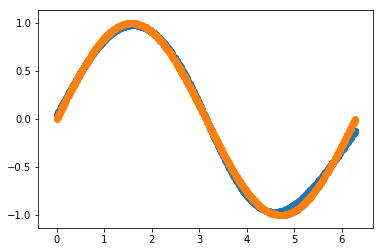

In [17]:
plt.scatter(X, nn.predict(X))
plt.scatter(X, y)
